In [1]:
import pandas as pd
import json

# Đường dẫn tới các file JSON
file_paths = {
    "user_video": r"D:\Data_labeling\user-video.json",
    "video": r"D:\Data_labeling\video.json",
}

# Hàm đọc file JSON và xử lý lỗi
def load_json_to_dataframe(file_path):
    rows = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:  # Đọc từng dòng trong file
            try:
                rows.append(json.loads(line))  # Chuyển dòng thành đối tượng JSON
            except json.JSONDecodeError as e:
                print(f"Lỗi đọc JSON tại file {file_path}, dòng: {line.strip()}, lỗi: {e}")
    return pd.DataFrame(rows) if rows else pd.DataFrame()  # Trả về DataFrame

# Tạo DataFrame cho từng file
user_video = load_json_to_dataframe(file_paths["user_video"])
video = load_json_to_dataframe(file_paths["video"])

In [2]:
# === Làm sạch bảng video ===
# 1. Loại bỏ giá trị thiếu
video.dropna()
# 2. Kiểm tra và loại bỏ giá trị âm hoặc không hợp lệ trong start, end
video["start"] = video["start"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
video["end"] = video["end"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def clean_time_data(start, end):
    clean_start, clean_end = [], []
    for s, e in zip(start, end):
        if s >= 0 and e > s:
            clean_start.append(s)
            clean_end.append(e)
    return clean_start, clean_end

video[["start", "end"]] = video.apply(
    lambda row: pd.Series(clean_time_data(row["start"], row["end"])), axis=1
)


In [3]:
import os
video_file = "video.xlsx"  # Tên file muốn lưu
video.to_excel(video_file, index=False)
os.startfile(video_file)

In [4]:
import ast
# === Làm sạch bảng user_video ===
# 1. Loại bỏ giá trị thiếu
user_video.dropna(subset=["seq", "user_id"], inplace=True)

# 2. chuyển đổi các cột không băm được sang định dạng chuỗi
user_video["seq"] = user_video["seq"].astype(str)


# Hàm làm sạch dữ liệu JSON trong cột 'seq'
def clean_seq_data(seq):
    try:
        # Chuyển chuỗi JSON thành danh sách Python
        if isinstance(seq, str):
            return ast.literal_eval(seq)
        return seq  # Nếu đã là danh sách thì giữ nguyên
    except Exception as e:
        print(f"Lỗi khi xử lý chuỗi JSON: {e}")
        return []

# Làm sạch cột 'seq'
user_video["seq"] = user_video["seq"].apply(clean_seq_data)



In [5]:


# Hàm xử lý để tính tổng thời gian học và tần suất từ bảng user_video
def calculate_video_stats(user_video_df):
    # Danh sách lưu trữ thông tin thống kê
    stats = []

    # Duyệt qua từng người dùng
    for _, row in user_video_df.iterrows():
        user_id = row['user_id']
        for record in row['seq']:
            video_id = record['video_id']
            total_study_time = 0
            frequency = 0
            
            # Tính thời gian học và số lần
            for segment in record['segment']:
                start = segment['start_point']
                end = segment['end_point']
                total_study_time += end - start  # Tính thời gian học
                frequency += 1  # Đếm tần suất
            
            # Lưu kết quả
            stats.append({
                "user_id": user_id,
                "video_id": video_id,
                "total_study_time": total_study_time,
                "frequency": frequency
            })
    
    # Trả về DataFrame thống kê
    return pd.DataFrame(stats)

# Tính toán thông tin tần suất và thời gian học
stats_df = calculate_video_stats(user_video)

# Gán nhãn dựa trên tổng thời gian học và tần suất
def assign_labels(row):
    # Gán nhãn thời gian học
    if row['total_study_time'] < 30:
        time_label = "Low"
    elif 30 <= row['total_study_time'] < 60:
        time_label = "Medium"
    else:
        time_label = "High"

    # Gán nhãn tần suất
    if row['frequency'] < 2:
        freq_label = "Low"
    elif 2 <= row['frequency'] < 5:
        freq_label = "Medium"
    else:
        freq_label = "High"
    
    return time_label, freq_label

# Áp dụng hàm gán nhãn
stats_df[['time_label', 'freq_label']] = stats_df.apply(assign_labels, axis=1, result_type="expand")


# Xuất kết quả
print(stats_df)

             user_id   video_id  total_study_time  frequency time_label  \
0              U_112  V_1395633            157.45          4       High   
1              U_112  V_1395635             35.00          1     Medium   
2              U_112  V_1395636             52.50          1     Medium   
3              U_112  V_1395639             12.50          2        Low   
4              U_112  V_6210799            319.25          4       High   
...              ...        ...               ...        ...        ...   
21295742  U_36053916  V_8156324              9.50          1        Low   
21295743  U_36053934  V_6268956            155.00          1       High   
21295744  U_36053946  V_6388141             10.00          1        Low   
21295745  U_36053952  V_8244595             45.00          6     Medium   
21295746  U_36053959  V_6106087             55.00          2     Medium   

         freq_label  
0            Medium  
1               Low  
2               Low  
3          

In [7]:
stats_df.to_csv("video_study_stats.csv", index=False)

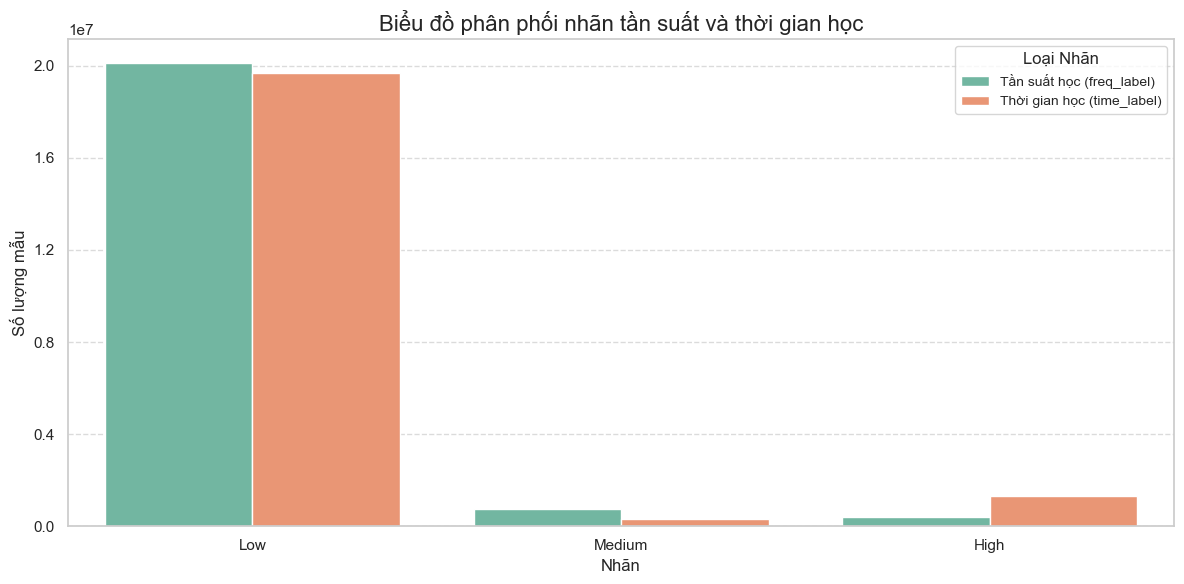

In [8]:
data = pd.read_csv("video_study_stats.csv")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")


# Tạo một DataFrame chứa phân phối nhãn
freq_label_dist = data['freq_label'].value_counts().reset_index()
freq_label_dist.columns = ['Label', 'Count']
freq_label_dist['Type'] = 'Tần suất học (freq_label)'

time_label_dist = data['time_label'].value_counts().reset_index()
time_label_dist.columns = ['Label', 'Count']
time_label_dist['Type'] = 'Thời gian học (time_label)'

# Kết hợp hai phân phối thành một DataFrame
combined_dist = pd.concat([freq_label_dist, time_label_dist], axis=0)

# Vẽ biểu đồ cột bằng seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=combined_dist,
    x='Label',
    y='Count',
    hue='Type',
    palette='Set2'
)

# Chỉnh bước nhảy trên trục Y
yticks = np.arange(0, combined_dist['Count'].max(), 4000000)
plt.yticks(yticks)

# Thêm tiêu đề, nhãn trục và chú thích
plt.title("Biểu đồ phân phối nhãn tần suất và thời gian học", fontsize=16)
plt.xlabel("Nhãn", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.legend(title="Loại Nhãn", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()